**Natural Language Processing**

Vinayak Gupta 18th May 2021

I have built a basic RNN, GRU and LSTM from scratch using nn.Module functions.
I have illustrated everything from scratch so if you are new to NLP. This would really help you get a good understanding of how RNN and LSTMs work.

I'll provide brief explanations and links for further reading wherever I can :)


**Dataset Download**

The dataset can be downloaded here https://download.pytorch.org/tutorial/data.zip


**Special note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.


In [1]:
# Dependencies

import io
import os 
import unicodedata
import string
import glob

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import random

**Mounting the Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Text Classification**

We are doing Name Classfication where given a input name of a person, the model predicts the place from where he is from.

Example: 

Input: Vladimir

Output: Russian

We are creating a string which contains all the letters from a to z in both lowercase and uppercase and including few special characters like .,:'

In [3]:
# alphabet small + capital letters + ".,:"
ALL_LETTERS = string.ascii_letters + " .,:'"
N_LETTERS = len(ALL_LETTERS)
print(ALL_LETTERS)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,:'


#**Data Refinement**

The function **unicode_to_ascii** converts special characters like Ś and Í to S and I respectively

The function load_data is used to load the data.

We use the glob.glob(path) function to retrieve paths recursively from inside the directories/files 
You can learn more about it from https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/

The function read_lines returns all the names of the person from a specific directory. Here it is filename

**os.path.basename()** is used to get the base name in specified path

**os.path.splitext()** is used to split the path name into a pair root and ext

You can learn more about them from 

os.path.basename: https://www.geeksforgeeks.org/python-os-path-basename-method/

os.path.splitext: https://www.geeksforgeeks.org/python-os-path-splitext-method/


In [4]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )
def load_data():
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('/content/drive/MyDrive/data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories

# The category_lines is a dictionary which contains the names of person from each respective country
# all_categories is a list which contains the names of all the different country

#**Data Processing**

The function letter_to_index returns the Letter index from the all_letters string, e.g. "a" = 0

The function letter_to_tensor turns the letter into a <1 x n_letters> Tensor like an one-hot encoding

The function line_to_tensor converts a line into a < line_length x 1 x n_letters> / an array of one hot letter vectors

Instead of taking the words in a batch we train it individually i.e we use batch_size = 1. We pick a random training example and train it on that

In [5]:
# Find Letter Index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1,N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a < line_length x 1 x n_letters>
# or an array of one hot letter vectors

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a)-1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


In [7]:
print(unicode_to_ascii('Ślusàrskî'))

category_lines, all_categories = load_data()
#print(category_lines['Italian'][:5])

print(letter_to_tensor('J'))
print(line_to_tensor('Jonas').size())

Slusarski
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


#**RNN**

![]('/content/drive/MyDrive/1150.png')

![]('https://drive.google.com/file/d/1W8apO87npO5lY7DNeOqTPBW26uBfXL3c/view?usp=sharing')

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
class GRU(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        self.i2u = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2r = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.hidden_next = nn.Linear(input_size + hidden_size, hidden_size)
        self.yhat = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        z = self.i2u(combined)
        z = self.sigmoid(z)
        r = self.i2r(combined)
        r = self.sigmoid(z)
        reset = r*hidden_tensor
        combined = torch.cat((input_tensor, reset), 1)
        hidden_bar = self.hidden_next(combined)
        hidden_bar = self.tanh(hidden_bar)
        hidden = (1-z)*hidden_tensor + z*hidden_bar
        output = self.yhat(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
        

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.i2f = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2i = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2c = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, hidden_size)
        self.yhat = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor, long_term_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        f = self.i2f(combined)
        f = self.sigmoid(f)
        i = self.i2i(combined)
        i = self.sigmoid(i)
        c = self.i2c(combined)
        c = self.tanh(c)
        Ct = f*long_term_tensor + i*c
        Ct = self.tanh(Ct)
        o = self.i2o(combined)
        o = self.sigmoid(o)
        hidden = o*Ct
        output = self.yhat(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

    def init_long_term(self):
        return torch.zeros(1, self.hidden_size)

We load the data. n_categories is the number of different class labels. n_hidden is the number of layers in the RNN

In [ ]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_hidden = 128

We can define rnn, gru or lstm. It is completely our choice. We have code for all 3 models. In this case I am using LSTM 

In [ ]:
# rnn = RNN(N_LETTERS, n_hidden, n_categories)
# gru = GRU(N_LETTERS, n_hidden, n_categories)
lstm = LSTM(N_LETTERS, n_hidden, n_categories)

In [ ]:
input_tensor = letter_to_tensor('A')
hidden_tensor = lstm.init_hidden()
long_term_tensor = lstm.init_long_term()
output,  next_hidden = lstm(input_tensor, hidden_tensor, long_term_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [ ]:
input_tensor = line_to_tensor('Albert')
hidden_tensor = lstm.init_hidden()
long_term_tensor = lstm.init_long_term()
output,  next_hidden = lstm(input_tensor[0], hidden_tensor, long_term_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [ ]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Portuguese


#**Training the model**

Alright, let's train the model now. We randomly choose a training sample and we use that as a batch(with batch_size = 1) and train on it(like SGD)

5000 5.0 0.0166 Villanueva / Spanish CORRECT  Accuracy: 0.9468
10000 10.0 2.6764 BestujevLada / Spanish WRONG (Russian)  Accuracy: 0.939
15000 15.0 1.4916 Vilson / English WRONG (Russian)  Accuracy: 0.9384
20000 20.0 0.0239 Columbo / Italian CORRECT  Accuracy: 0.9388
25000 25.0 0.0324 Patenaude / French CORRECT  Accuracy: 0.9494
30000 30.0 0.0300 Fuentes / Spanish CORRECT  Accuracy: 0.9462
35000 35.0 0.0562 Fergus / Irish CORRECT  Accuracy: 0.9484
40000 40.0 0.0000 Astrakhantsev / Russian CORRECT  Accuracy: 0.9412
45000 45.0 0.0049 Pinheiro / Portuguese CORRECT  Accuracy: 0.9456
50000 50.0 0.0300 Favre / French CORRECT  Accuracy: 0.945
55000 55.0 0.0198 Archambault / French CORRECT  Accuracy: 0.9462
60000 60.0 0.4448 Kim / Vietnamese CORRECT  Accuracy: 0.9386
65000 65.0 2.7306 Vaver / German WRONG (Russian)  Accuracy: 0.944
70000 70.0 0.0127 Prinsen / Dutch CORRECT  Accuracy: 0.9374
75000 75.0 0.1718 Geryk / Czech CORRECT  Accuracy: 0.9414
80000 80.0 1.5219 Basurto / Portuguese WRONG (

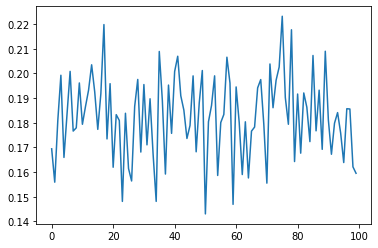

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = lstm.init_hidden()
    long_term_tensor = lstm.init_long_term()
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden, long_term_tensor)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
accuracy = 0

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    guess = category_from_output(output)
    if guess == category:
        accuracy = accuracy + 1 
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT"if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100:.1f} {loss:.4f} {line} / {guess} {correct}  Accuracy: {accuracy/5000}")
        accuracy = 0

plt.figure()
plt.plot(all_losses)
plt.show()


In [ ]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)
predict('Buttler')


> Jo
Korean
